In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
vix_data = yf.download('^VIX', start='2019-01-01', end='2024-11-01', interval='1d')
vix=vix_data['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [4]:
# Setting the frequency of the data
vix = vix.asfreq('D').ffill()  # forward fill to handle missing values

In [5]:
# Initial data preview
print(vix.head())

Ticker                          ^VIX
Date                                
2019-01-02 00:00:00+00:00  23.219999
2019-01-03 00:00:00+00:00  25.450001
2019-01-04 00:00:00+00:00  21.379999
2019-01-05 00:00:00+00:00  21.379999
2019-01-06 00:00:00+00:00  21.379999


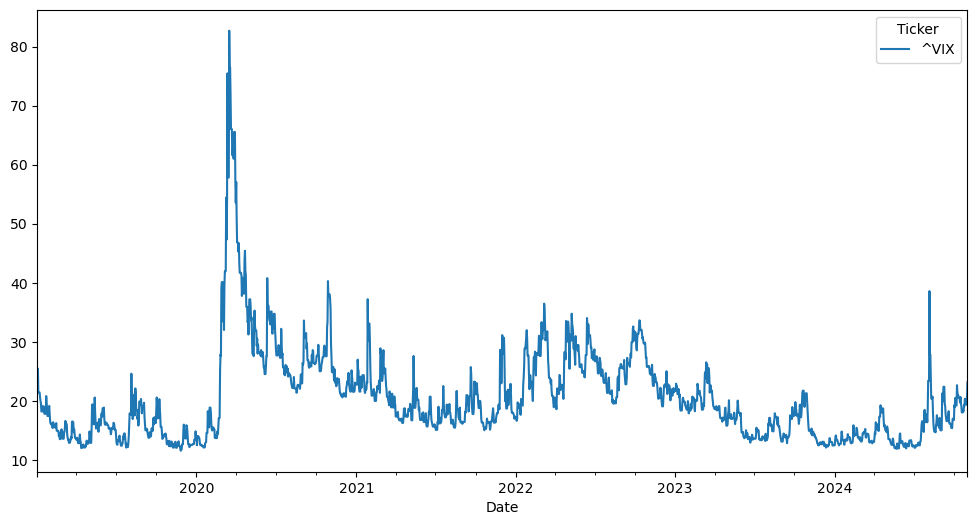

In [6]:
# Plotting the data
vix.plot(figsize=(12, 6))
plt.show()

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

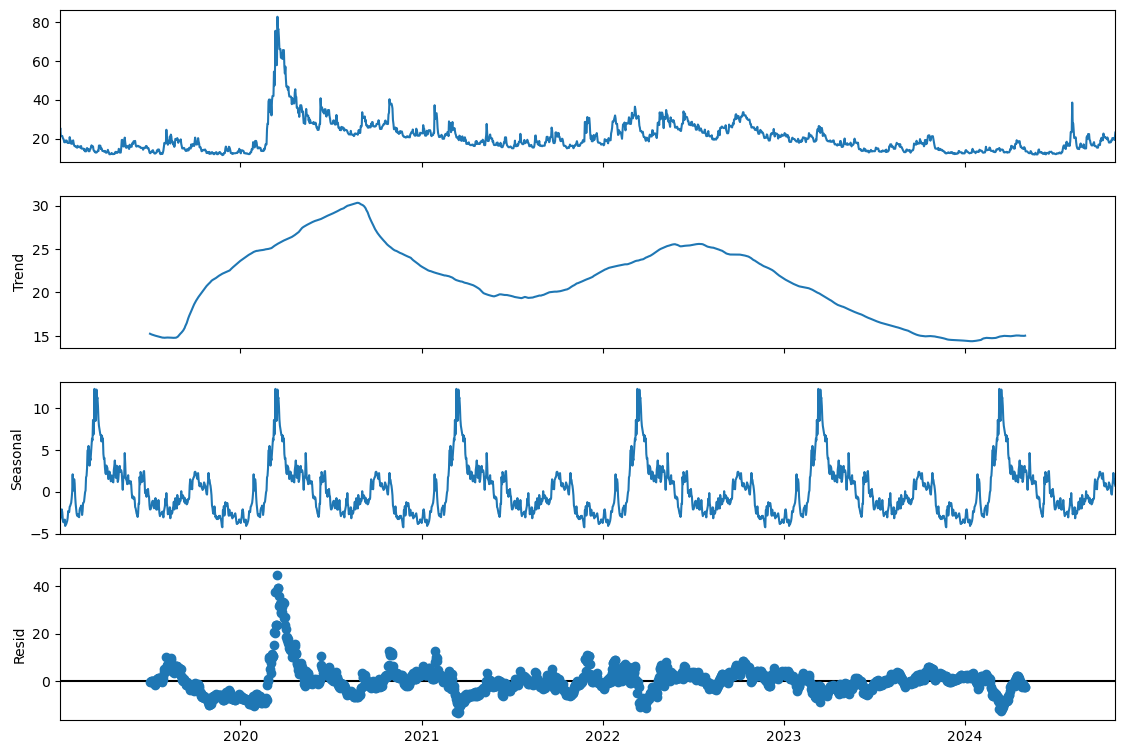

In [8]:
# Decomposing the time series
results = seasonal_decompose(vix, model='additive', period=365)  # assuming yearly seasonality
fig = results.plot()

# Adjust the size of the plots
fig.set_size_inches(12, 8)
plt.show()

In [9]:
len(vix)

2130

In [10]:
train = vix.iloc[:1712]
test = vix.iloc[1712:]

In [11]:
# preprocess data - convert it into (0, 1) scale
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

In [12]:
# Ensure 'train' and 'test' are NumPy arrays
train_array = train.values.reshape(-1, 1)
test_array = test.values.reshape(-1, 1)

# Fit the scaler on the training data
scaler.fit(train_array)

# Transform both the training and test data
scaled_train = scaler.transform(train_array)
scaled_test = scaler.transform(test_array)


In [13]:
'''# Fit the scaler on the entire dataset
scaler.fit(vix.values.reshape(-1, 1))
scaled_vix = scaler.transform(vix.values.reshape(-1, 1))'''

'# Fit the scaler on the entire dataset\nscaler.fit(vix.values.reshape(-1, 1))\nscaled_vix = scaler.transform(vix.values.reshape(-1, 1))'

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
# Assuming scaled_train is previously defined and properly scaled dataset
n_input = 21 # monthly
n_features = 1  # Number of features per step (often 1 for univariate time series)

# Define generator
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
#generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1, end_index=len(scaled_train)-n_output)


In [16]:
print(len(scaled_train), len(generator))

1712 1691


In [17]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.16416021 0.19550246 0.13829935 0.13829935 0.13829935 0.13858045
 0.12550947 0.11862262 0.11187631 0.09346452 0.09346452 0.09346452
 0.10583274 0.09922699 0.10541111 0.09163738 0.08798312 0.08798312
 0.08798312 0.08798312 0.13014756]
Predict this y: 
 [[0.11215742]]


In [18]:
X.shape

(1, 21, 1)

In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
# define model
'''model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_input, n_features)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')'''

"model = Sequential()\nmodel.add(LSTM(50, return_sequences=True, input_shape=(n_input, n_features)))\nmodel.add(Dropout(0.2))\nmodel.add(Bidirectional(LSTM(50)))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(1))\nmodel.compile(optimizer='adam', loss='mse')"

In [21]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# fit model
model.fit(generator, epochs=50)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1691/1691 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0037
Epoch 2/50
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0012
Epoch 3/50
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.2722e-04
Epoch 4/50
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.9975e-04
Epoch 5/50
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.5912e-04
Epoch 6/50
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0011
Epoch 7/50
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.5142e-04
Epoch 8/50
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.2926e-04
Epoch 9/50
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.6141e-04
Epoch 10/50
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.5191e-04
Epoch 11/50
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.8596e-04
Epoch 12/50
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.6605e-04
Epoch 13/50
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.8559e-04
Epoch 14/50
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.6761e

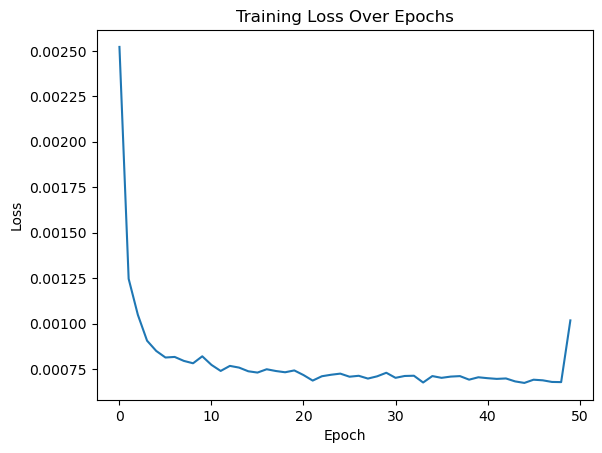

In [24]:
# Plot the training loss
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [25]:
last_train_batch = scaled_train[-n_input:]

In [26]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [27]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


array([[0.0458424]], dtype=float32)

In [33]:
scaled_train[0]

array([0.16416021])

In [35]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(scaled_test)):
    # Get the prediction value for the current batch
    current_pred = model.predict(current_batch)
    # Append the prediction to the list
    test_predictions.append(current_pred[0][0])
    # Get the true value from scaled_test
    true_value = scaled_test[i]
    # Update current_batch with the true value
    true_value_reshaped = true_value.reshape(1, 1, 1)
    current_batch = np.concatenate((current_batch[:,1:,:], true_value_reshaped), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [37]:
test_predictions

[0.0458424,
 0.04601091,
 0.04544489,
 0.050984718,
 0.041245796,
 0.033206843,
 0.0449702,
 0.045241855,
 0.04505144,
 0.047851272,
 0.049361274,
 0.06271953,
 0.09384833,
 0.08986637,
 0.08939853,
 0.089948475,
 0.086231045,
 0.11278936,
 0.10368411,
 0.091452725,
 0.094339475,
 0.0945319,
 0.09424536,
 0.0953224,
 0.12352502,
 0.10802731,
 0.10620119,
 0.09330596,
 0.09335832,
 0.09349787,
 0.096501775,
 0.08758269,
 0.07515738,
 0.08325361,
 0.11747579,
 0.11750754,
 0.116799295,
 0.08961238,
 0.09890256,
 0.11693746,
 0.14477849,
 0.14868626,
 0.14825968,
 0.1487861,
 0.1314492,
 0.11318062,
 0.12989047,
 0.13620518,
 0.1430132,
 0.14293525,
 0.14292602,
 0.12306461,
 0.102027416,
 0.086333856,
 0.07059993,
 0.060421795,
 0.05966147,
 0.05902414,
 0.058748156,
 0.057862945,
 0.053260684,
 0.064301275,
 0.04990989,
 0.049816705,
 0.050098523,
 0.057741694,
 0.049941555,
 0.050081253,
 0.052089065,
 0.045309424,
 0.04526086,
 0.045371324,
 0.040250503,
 0.039474286,
 0.03335174,
 0.

In [39]:
test.head()

Ticker,^VIX
Date,
2023-09-10 00:00:00+00:00,13.84
2023-09-11 00:00:00+00:00,13.80
2023-09-12 00:00:00+00:00,14.23
2023-09-13 00:00:00+00:00,13.48
2023-09-14 00:00:00+00:00,12.82


In [41]:
test_predictions = np.array(test_predictions)
test_predictions = test_predictions.reshape(-1, 1)
true_predictions = scaler.inverse_transform(test_predictions)

In [43]:
print(f"Length of true_predictions: {len(true_predictions)}")
print(f"Length of test DataFrame: {len(test)}")

Length of true_predictions: 418
Length of test DataFrame: 418


In [45]:
test['Predictions'] = true_predictions

/var/folders/p7/gwhw97kd1rdg70ntnf_trfcm0000gp/T/ipykernel_8747/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

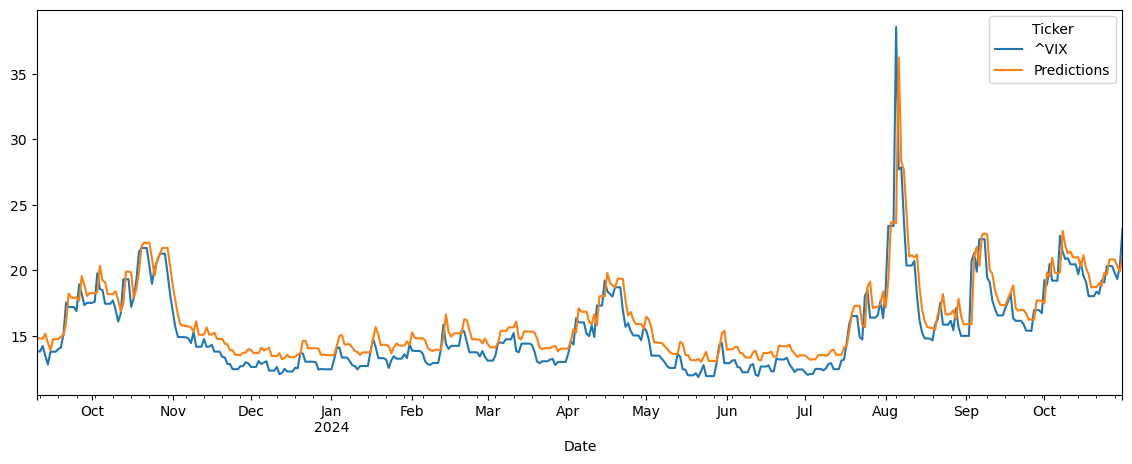

In [47]:
test.plot(figsize=(14,5))

In [49]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['^VIX'],test['Predictions']))
#rmse = sqrt(mean_squared_error(test['Adj Close'], test['Predictions']))
print(rmse)

1.491919827140632
